<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Mickael/notebooks/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [ ]:
!pip install nussl

In [ ]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

In [ ]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

# Montage du drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [5]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

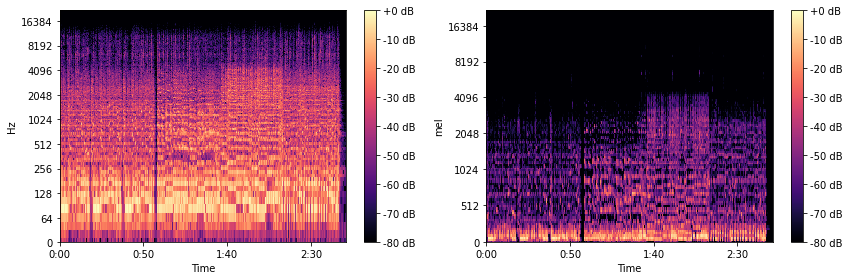

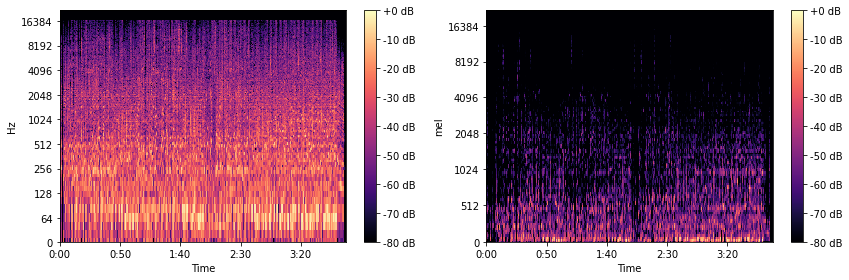

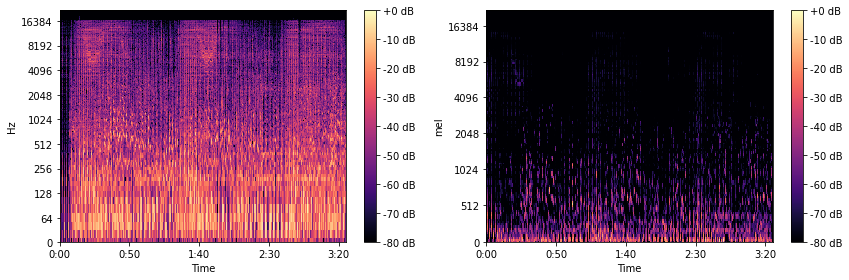

In [ ]:
for i in range(3):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis='log')
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb[i]['mix'],y_axis="mel")
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Spectrogrammes et création du dataset

In [6]:
def preprocess(music_data,
               freq=8192,
               window_length=1023,
               hop_length=768):
  
  # Spectro voix et mix
  voice = music_data['sources']["vocals"]
  mix = music_data['mix']

  # Resampling à 16 kHz (pour data plus light)
  voice=librosa.resample(voice.audio_data,voice.sample_rate,freq,res_type='kaiser_fast')
  mix  =librosa.resample(mix.audio_data,mix.sample_rate,freq,res_type='kaiser_fast')

  # Passage en mono
  voice = librosa.to_mono(voice)
  mix   = librosa.to_mono(mix)

  # fft mix et voix (magnitude normalisée et phase)
  stftvoice = librosa.stft(voice,n_fft=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = librosa.stft(mix,n_fft=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  norm = magmix.max()
  magmix /= norm
  magvoice /= norm

  return magmix, magvoice, phasemix

In [7]:
def reshape(X_mix, X_voice, patch_size=128):
  # transposition pour mettre le temps en première composante  
  X_mix = X_mix.T
  X_voice = X_voice.T

  # split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
  nimages = X_mix.shape[0]//patch_size   # nombre total d'images
  newsize = nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

  X_mix_resized = X_mix[:newsize]
  X_voice_resized = X_voice[:newsize]

  X_mix = np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
  X_voice = np.array(np.split(X_voice_resized, nimages, axis=0))

  X_mix = np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
  X_voice = np.expand_dims(X_voice,axis=3)

  return X_mix, X_voice

In [8]:
def data_generator(all_data,
                   batch_size=10,
                   nfreq=512,
                   freq=8192,
                   window_length=1023,
                   hop_length=768,
                   patch_size=128):
  # Mix as input, voice as output
  X_mix = np.empty((nfreq,0))
  X_voice = np.empty((nfreq,0))
  while True:

    for i,data in enumerate(all_data):

      magmix, magvoice, _ = preprocess(data, freq, window_length, hop_length)
      X_mix = np.append(X_mix, magmix, axis=1)
      X_voice = np.append(X_voice, magvoice, axis=1)

      if((i+1)%batch_size == 0 or i+1 == len(all_data)):

        X_mix, X_voice = reshape(X_mix, X_voice, patch_size)

        yield X_mix, X_voice

        X_mix = np.empty((nfreq,0))
        X_voice = np.empty((nfreq,0))

In [56]:
a = data_generator(musdb_train,batch_size=2)
print("Testing, should be (34, 128, 512, 1)")
print(next(a)[0].shape)

Testing, should be (34, 128, 512, 1)
(34, 128, 512, 1)


On calcule les spectrogrammes du mix (données d'entrée) et du vocals (ground truth). Les spectres sont concaténés puis découpés pour former une "image" (donnée d'entrée du U-net).
Rem. : faire une fonction, ce serait plus propre

In [14]:
# paramètres de la STFT
freq        =8192     # fréquence de reéchantillonage

window_length =1023    # taille fenêtre FFT
hop_length    =768     # recouvrement FFT

patch_size = 128      # taille du patch temporel pour le CNN (=128 frames temporels)


npistes=2#len(musdb_train)

k=0
time=0
for npiste in range(npistes):

  magmix, magvoice, phasemix = preprocess(musdb_train[npiste])

  # concatenation
  k=k+1
  if (k==1):
    X_mix   =magmix
    X_voice =magvoice
    phase   =phasemix
  else:
    X_mix  =np.append(X_mix,magmix,axis=1)
    X_voice=np.append(X_voice,magvoice,axis=1)
    phase  =np.append(phase,phasemix,axis=1)


# transposition pour mettre le temps en première composante  
X_mix=X_mix.T
X_voice=X_voice.T
phase=phase.T

nfreq=X_mix.shape[1] 

# split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
nimages=X_mix.shape[0]//patch_size   # nombre total d'images
newsize=nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

print('Data set: ',k, 'songs')
print('Data set: ',time, 'total time (s)')
print('Data set: ',nimages, 'training images with size',patch_size,'x',nfreq)

X_mix_resized  =X_mix  [:newsize,:]
X_voice_resized=X_voice[:newsize,:]
phase_resized=phase[:newsize,:]

X_mix=np.array(np.split(X_mix_resized, nimages, axis=0))    # découpage 
X_voice=np.array(np.split(X_voice_resized, nimages, axis=0))
phase=np.array(np.split(phase_resized, nimages, axis=0))

X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
X_voice=np.expand_dims(X_voice,axis=3)


Data set:  2 songs
Data set:  0 total time (s)
Data set:  34 training images with size 128 x 512


In [39]:
X_mix.shape

(34, 128, 512, 1)

# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU

# Rem. dimensionnement du papier  nframes=128 nfreq=512

nframes = 128
nfreq = 512
batch_size = 5
data_gen = data_generator(musdb_train,
                          batch_size=batch_size,
                          patch_size=nframes)

# Création de la structure

inputs=Input(shape =(nframes,nfreq,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)
deconv12 = ReLU()(deconv12)

unet = Model(inputs=inputs, outputs=deconv12)
unet.summary()

#essai sur la norme du spectre direct (pas de masque)

unet.compile(loss='mean_absolute_error',   
              optimizer='adam')            

#train_history=unet.fit(X_mix,X_voice,
#                       validation_split=0.1,
#                       epochs=5,
#                       batch_size=16)

train_history = unet.fit_generator(data_gen,
                                   epochs=2,
                                   steps_per_epoch=np.ceil(len(musdb_train)/batch_size))



#définition de la loss function 
#def myloss(y_true, y_pred):
#    return tf.reduce_mean(squared_difference, axis=-1) 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 256, 16)  416         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 256, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/2
20/20 [==============================] - 1552s 81s/step - loss: 0.0105
Epoch 2/2
20/20 [==============================] - 1651s 83s/step - loss: 0.0036


True mix


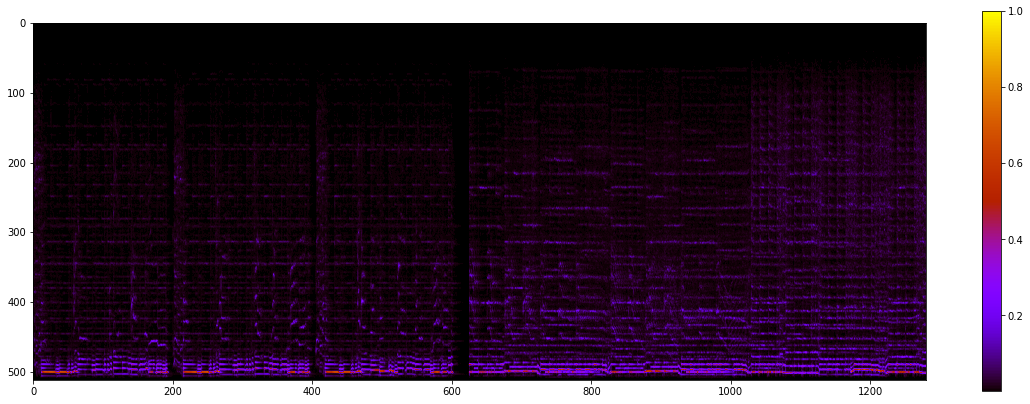

True voice


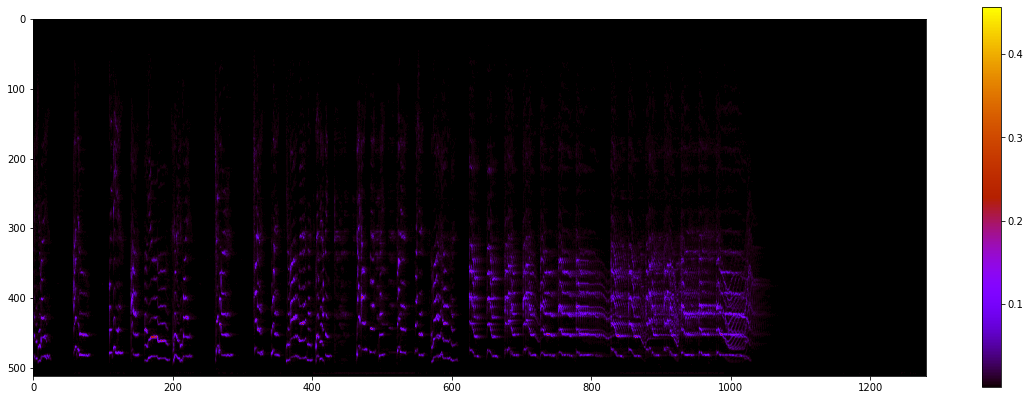

Predicted voice


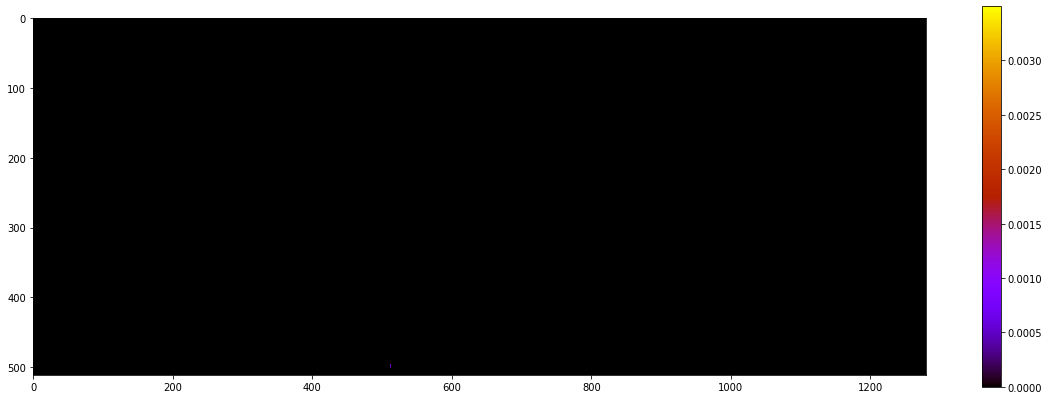

In [41]:
magmix, magvoice, _ = preprocess(musdb_train[0])
X_mix, X_voice = reshape(magmix, magvoice, 128)

print("True mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

print("True voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10,:,:,:].reshape(-1,nframes,nfreq,1))
print("Predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(10)])
plt.imshow(mix_to_plot[:,::-1,0].T,cmap="gnuplot")
plt.colorbar()
plt.show()

Log of true mix


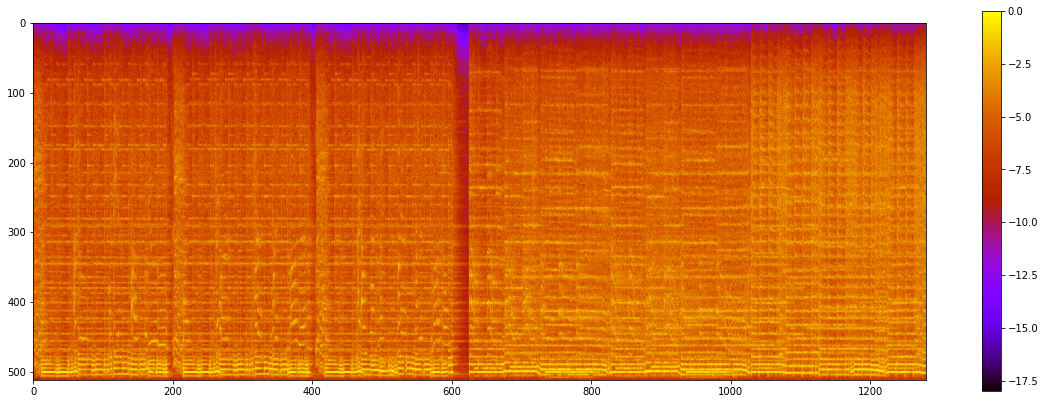

Log of true voice


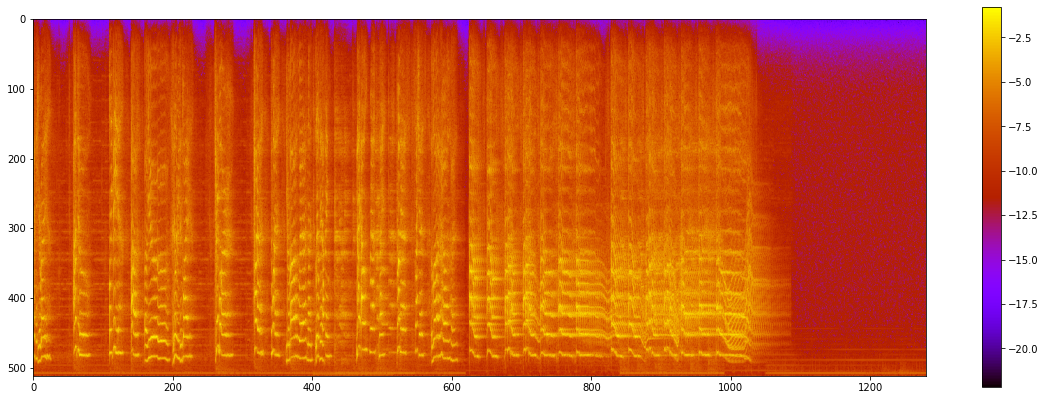

Log of predicted voice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


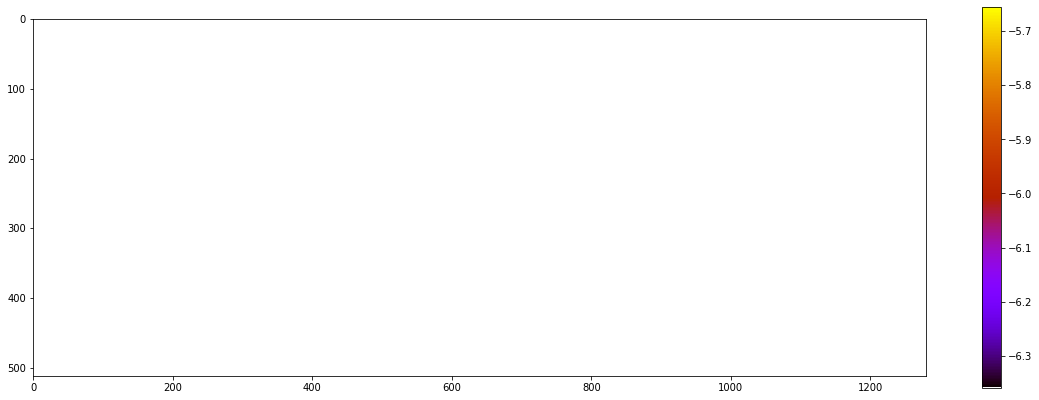

In [45]:
magmix, magvoice, _ = preprocess(musdb_train[0])
X_mix, X_voice = reshape(magmix, magvoice, 128)

print("Log of true mix")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_mix[i] for i in range(10)])
plt.imshow(np.log(mix_to_plot[:,::-1,0].T),cmap="gnuplot")
plt.colorbar()
plt.show()

print("Log of true voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([X_voice[i] for i in range(10)])
plt.imshow(np.log(mix_to_plot[:,::-1,0].T),cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix[0:10,:,:,:].reshape(-1,nframes,nfreq,1))
print("Log of predicted voice")
plt.figure(figsize=(20,7))
mix_to_plot = np.concatenate([ytest[i] for i in range(10)])
plt.imshow(np.log(mix_to_plot[:,::-1,0].T),cmap="gnuplot")
plt.colorbar()
plt.show()

# Evaluations

In [ ]:
# essai de sortie d'une prédiction à écouter (sur Xmix[0] )
ytest =unet.predict(X_mix[0,:,:,:].reshape(-1,nframes,nfreq,1))

voicesep=ytest.reshape(nframes,nfreq)*phase[0,:,:]
y = librosa.istft(voicesep.T, window_length,hop_length)

signal = nussl.AudioSignal(audio_data_array=y, sample_rate=freq)
signal.embed_audio()
print(signal)



AudioSignal (unlabeled): 15.859 sec @ path unknown, 8192 Hz, 1 ch.
